# This code is a cross-validation for CL
- no filter for all CL, CD
- bessel filter for CP |  bessel filter; $w_n = 0.01$, the frequence based on Nyquist rate (=sample_freq/2) is: $0.01*1000/2=5$
- no standardization; no normalization
- with L2
- activation func: PReLU
- No CP'(t), CP''(t) !!!


# Define which task to run:
- task  = ['predict', 'cross_validation']
    - 'cross_validation': for cross validation; has 7 folds
    - 'predict': for test using parameters chose by cross validation; has 1 fold --> fold8
- force = ['CL', 'CD']
- filt  = ['bessel', 'no filter']

In [1]:
task = 'cross_validation' 
force = 'CL'     
filt = 'bessel'  # only for cp; no cl or cd filter

if task == 'cross_validation':
    folds = 7
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

Define the task complete.


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics, regularizers
from tensorflow.keras.layers import Activation, Dense, Input

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 使用第二，三块GPU "2,3"（从0开始）


2023-01-16 18:54:26.414534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 18:54:26.485634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-16 18:54:26.485646: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-16 18:54:26.849016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import datetime
import time
import pandas as pd
from scipy.signal import bessel
from scipy.signal import filtfilt


In [4]:
# initialize the data
history_all = {}
predictions = {}

# folder path
data_path = 'gust_dataframe.xlsx'

# read the excel data
gust_origin = pd.read_excel(data_path)

In [5]:
gust_origin.head()

,case_number,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
0,case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
1,case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
2,case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
3,case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
4,case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [6]:
# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

(80000, 18)


,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-1.020413,-0.610013,-0.776402,-0.992375,-0.427389,-0.471947,-0.578770,-0.767883,-1.005905,-0.242947,-0.281585,-0.324500,-0.398877,-0.580220,-1.233073,0.889897,0.533331,0.125085
case_01,-1.018687,-0.608741,-0.777038,-0.988559,-0.426753,-0.471221,-0.572956,-0.767793,-1.005815,-0.244037,-0.290489,-0.330588,-0.403783,-0.581219,-1.233618,0.891896,0.520047,0.117766
case_01,-1.027681,-0.610286,-0.781126,-0.999098,-0.418213,-0.483122,-0.565142,-0.742717,-1.013083,-0.240766,-0.283311,-0.323319,-0.398604,-0.582037,-1.229530,0.899073,0.527826,0.136049
case_01,-1.029044,-0.612739,-0.789030,-0.994555,-0.420121,-0.474855,-0.562689,-0.717641,-1.015808,-0.243038,-0.282130,-0.324046,-0.394698,-0.586307,-1.229802,0.900709,0.546522,0.142592
case_01,-1.020867,-0.613284,-0.797571,-0.992466,-0.411490,-0.469676,-0.574954,-0.699834,-1.012538,-0.244128,-0.285128,-0.329406,-0.388156,-0.589487,-1.221171,0.904797,0.518274,0.123129


In [7]:
# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((gust_index.nunique(),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((gust_index.nunique(),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j]) # bessel filter for cp
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

In [8]:
# check gust
gust.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t,CL,CD
case_number,,,,,,,,,,,,,,,,,,
case_01,-0.990365,-0.587135,-0.749435,-0.959071,-0.410622,-0.453780,-0.558437,-0.740425,-0.992490,-0.240840,-0.273488,-0.320183,-0.390432,-0.578353,-1.210461,0.910885,0.533331,0.125085
case_01,-0.989840,-0.586657,-0.749167,-0.958629,-0.410261,-0.453455,-0.558073,-0.739895,-0.992267,-0.240657,-0.273358,-0.320067,-0.390329,-0.578032,-1.209803,0.912125,0.520047,0.117766
case_01,-0.989313,-0.586177,-0.748897,-0.958186,-0.409900,-0.453128,-0.557707,-0.739367,-0.992042,-0.240473,-0.273227,-0.319951,-0.390227,-0.577709,-1.209143,0.913366,0.527826,0.136049
case_01,-0.988785,-0.585696,-0.748627,-0.957741,-0.409539,-0.452802,-0.557340,-0.738839,-0.991817,-0.240288,-0.273096,-0.319834,-0.390123,-0.577385,-1.208482,0.914606,0.546522,0.142592
case_01,-0.988256,-0.585214,-0.748356,-0.957294,-0.409178,-0.452475,-0.556971,-0.738311,-0.991592,-0.240102,-0.272963,-0.319717,-0.390020,-0.577061,-1.207821,0.915848,0.518274,0.123129


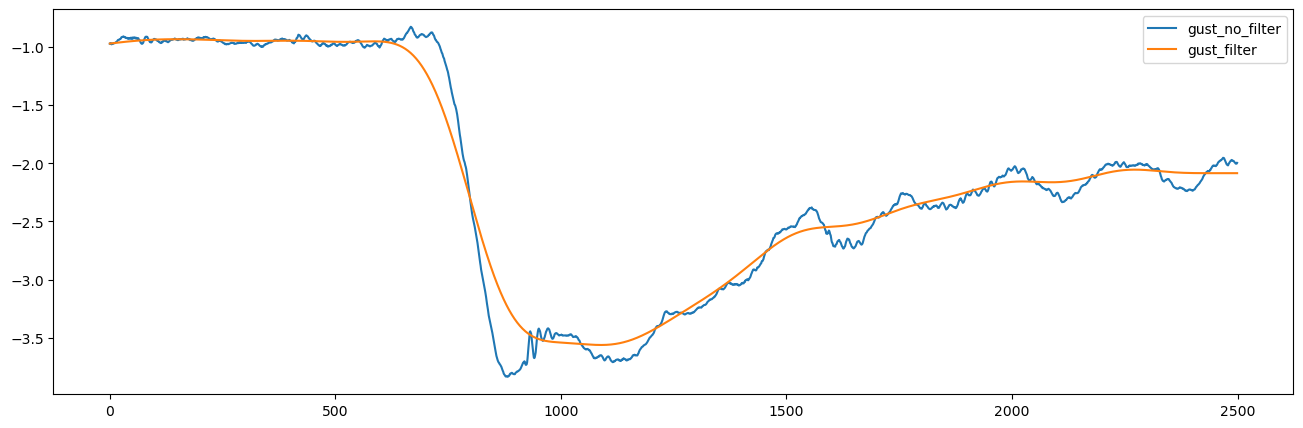

In [9]:
# check filter result
if filt == 'bessel':
    ii = 16 # case to show
    case_to_show = 'case_' + str(ii+1).zfill(2)
    cp_to_show   = 1
    fig,ax = plt.subplots(figsize=(16,5))
    ax.plot(gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show],label='gust_no_filter')
    ax.plot(gust.loc[[case_to_show]].to_numpy()[:,cp_to_show],label='gust_filter')
    ax.legend()
elif filt == 'no filter':
    print('No filter. No compare.')
else:
    print('Error. Please define your filter.')

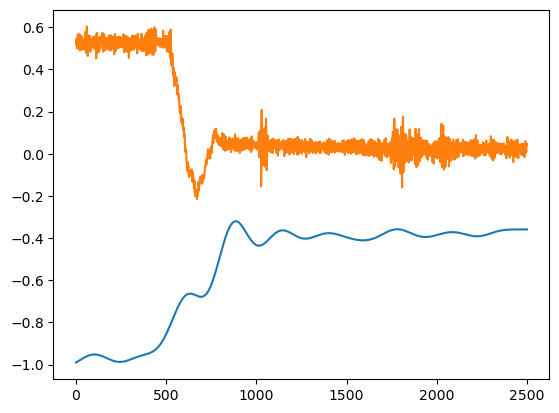

In [10]:
plt.plot(gust[['Cp1_t']].to_numpy()[0:2500,0])
plt.plot(gust[['CL']].to_numpy()[0:2500,0])

In [11]:
# retrieve CP = 16 columns in total
# simply drop CL and CD, then the rest is CP
CP = gust.drop(['CL','CD'],axis=1, inplace=False)
CP.head()

,Cp1_t,Cp2_t,Cp3_t,Cp4_t,Cp5_t,Cp6_t,Cp7_t,Cp8_t,Cp9_t,Cp10_t,Cp12_t,Cp13_t,Cp14_t,Cp15_t,Cp16_t,Cp0_t
case_number,,,,,,,,,,,,,,,,
case_01,-0.990365,-0.587135,-0.749435,-0.959071,-0.410622,-0.453780,-0.558437,-0.740425,-0.992490,-0.240840,-0.273488,-0.320183,-0.390432,-0.578353,-1.210461,0.910885
case_01,-0.989840,-0.586657,-0.749167,-0.958629,-0.410261,-0.453455,-0.558073,-0.739895,-0.992267,-0.240657,-0.273358,-0.320067,-0.390329,-0.578032,-1.209803,0.912125
case_01,-0.989313,-0.586177,-0.748897,-0.958186,-0.409900,-0.453128,-0.557707,-0.739367,-0.992042,-0.240473,-0.273227,-0.319951,-0.390227,-0.577709,-1.209143,0.913366
case_01,-0.988785,-0.585696,-0.748627,-0.957741,-0.409539,-0.452802,-0.557340,-0.738839,-0.991817,-0.240288,-0.273096,-0.319834,-0.390123,-0.577385,-1.208482,0.914606
case_01,-0.988256,-0.585214,-0.748356,-0.957294,-0.409178,-0.452475,-0.556971,-0.738311,-0.991592,-0.240102,-0.272963,-0.319717,-0.390020,-0.577061,-1.207821,0.915848


In [12]:
# retrieve CL and CD
CL = gust[['CL']]
CD = gust[['CD']]
CL.head()
CD.head()

,CD
case_number,
case_01,0.125085
case_01,0.117766
case_01,0.136049
case_01,0.142592
case_01,0.123129


In [13]:
# retrieve for 8 different folds
# read the split .txt file; the number means the cases for test
split_path = 'delta_wing_32cases_split_random.txt'
with open(split_path, 'r') as file1:    
    fold_split = file1.read().splitlines()       # split by \n
fold_split = fold_split[1:] # drop the head line
for i in range(8):
    fold_split[i] = fold_split[i][9:].split()    # split by space; the number starts from 10th character.
    for j in range(4):
        fold_split[i][j] = int(fold_split[i][j]) # convert string to int
fold_split

[[4, 19, 26, 30],
 [5, 14, 31, 32],
 [1, 18, 22, 29],
 [6, 10, 16, 17],
 [2, 8, 11, 24],
 [3, 7, 15, 27],
 [9, 12, 21, 23],
 [13, 20, 25, 28]]

In [14]:
# define the 32 case number
case_all_num = np.arange(gust.index.nunique()) + 1
print(case_all_num)
print(case_all_num.size)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
32


In [15]:
# find the case number for train and test cases;
if task == 'cross_validation':
    train_case = [ [0]*24 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for cross validation folds: fold1~fold7
    for i in range(folds): 
        train_case_temp = np.setdiff1d( case_all_num, np.concatenate((fold_split[i], fold_split[-1]))) 
        # drop test case and the last one (which is for fold 8 , final test)
        test_case_temp  = fold_split[i]

        # conbine to 'case_nn' sample for train and test case; prepare for next step
        for j in range(len(train_case_temp)):
            train_case[i][j] = 'case_' + str(train_case_temp[j]).zfill(2)
        for k in range(len(test_case_temp)):
            test_case[i][k]  = 'case_' + str(test_case_temp[k]).zfill(2)
            
elif task == 'predict': 
    train_case = [ [0]*28 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for test fold: fold8  
    train_case_temp = np.setdiff1d(case_all_num, fold_split[-1])
    test_case_temp  = fold_split[-1]
    for jj in range(len(train_case_temp)):
        train_case[-1][jj] = 'case_' + str(train_case_temp[jj]).zfill(2)
    for kk in range(len(test_case_temp)):
        test_case[-1][kk]  = 'case_' + str(test_case_temp[kk]).zfill(2)

else:
    print('Error. Please define your task.')

print('Done!')

Done!


In [16]:
print(train_case[0])
print(test_case[0])

['case_01', 'case_02', 'case_03', 'case_05', 'case_06', 'case_07', 'case_08', 'case_09', 'case_10', 'case_11', 'case_12', 'case_14', 'case_15', 'case_16', 'case_17', 'case_18', 'case_21', 'case_22', 'case_23', 'case_24', 'case_27', 'case_29', 'case_31', 'case_32']
['case_04', 'case_19', 'case_26', 'case_30']


In [17]:
print(task)
print(force)

cross_validation
CL


In [18]:
#  prepare for train and test data sets
if task == 'cross_validation':
    F_train_rec = np.zeros([folds,60000,1]) # 24*2500 = 60000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,60000,16])
    P_test_rec  = np.zeros([folds,10000,16])

    for i in range(folds): # 7 folds for training, the last one is for test, not retrieve here, since this is for training
        if force == 'CL':
            F_train_rec[i] = CL.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CL.loc[test_case[i]].to_numpy()
        elif force == 'CD':
            F_train_rec[i] = CD.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CD.loc[test_case[i]].to_numpy()
        else:
            print('Error. Please define force.')

        P_train_rec[i] = CP.loc[train_case[i]].to_numpy()
        P_test_rec[i]  = CP.loc[test_case[i]].to_numpy()

elif task == 'predict':
    F_train_rec = np.zeros([folds,70000,1]) # 28*2500 = 70000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,70000,16])
    P_test_rec  = np.zeros([folds,10000,16])
    
    if force == 'CL':
        F_train_rec[0] = CL.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CL.loc[test_case[0]].to_numpy()
    elif force == 'CD':
        F_train_rec[0] = CD.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CD.loc[test_case[0]].to_numpy()
    else:
        print('Error. Please define force.')

    P_train_rec[0] = CP.loc[train_case[0]].to_numpy()
    P_test_rec[0]  = CP.loc[test_case[0]].to_numpy()
    
else:
    print('Error. Please define your task.')
    
print('Done')

Done


In [19]:
''' begin training '''

from keras.models import load_model
from keras.layers import LeakyReLU, PReLU 

num_neuron = [16, 24, 32, 40, 48, 56, 64, 72]
num_layer  = [6]#[1,2,3,4,5,6,7,8]
epoch_total = 200 # 200 #l1_n8:193; l1_n16:196; l1_n24:189; l1_n32:166
weight_decay = 0 # 5e-4 # l2 regularization hyperparameter | no L2, as there is noise in CL
learn_rate   = 1e-5 # 1e-3
batch_how    = 200  # 200

# define callback: predict on each epoch
class prediction_for_each_epoch(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_predictions = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_predictions.append(model.predict(P_test))
        
# record start time
starttime = datetime.datetime.now()
# sleep 2 seconds
time.sleep(0)

for i in num_neuron: # define the neurons
    
    for j in num_layer: # define the hidden layers
        
        for k in range(folds): # start loop; if folds=7, then do cross validation; if folds=1, then, do predict
            
            print('start fold'+str(k+1).zfill(2)+' | layer'+str(j)+' |neuron'+str(i))
            
            predictions[k,i,j]=prediction_for_each_epoch()
            
            F_train = F_train_rec[k][:,:]   # change to 2d for training
            F_test  = F_test_rec[k][:,:]
            P_train = P_train_rec[k][:,:]
            P_test  = P_test_rec[k][:,:]
            '''load data done'''
            
            model = Sequential()

            neuron = i

            # ##### build the model #####
            
            # Input layer, no activation for input layer, no L2
            model.add(Input(shape=(16,)))  
            
            # Hidden layer
            for jj in range(j):       
                model.add(Dense(neuron, kernel_regularizer=regularizers.l2(weight_decay))) 
                model.add(PReLU())
            
            # Output layer => output dimension = 1 since it is regression problem; no activation for output layer
            model.add(Dense(1, activation = 'linear', kernel_regularizer=regularizers.l2(weight_decay)))   
            
            model.summary()
            
            adam = optimizers.Adam(learning_rate = learn_rate)    
            
            model.compile(optimizer = adam, loss = 'mean_squared_error')#, metrics = ['mean_absolute_error'])    
            # for regression problems, mean squared error (MSE) is often employed; 
            # do not use 'accuracy', as this is used for classification problem
            
            # # load model, only for continuing training
            # model = load_model('neuron_' + str(num_neuron[0]) + '_layer_' + str(num_layer[0]) + '.h5')
            
            '''history_all[i,j] = '''
            model.fit(P_train, F_train, batch_size = batch_how, epochs = epoch_total, verbose = 2, shuffle=False, 
                                         validation_split=0.0, callbacks=[predictions[k,i,j]]) 
            # no shuffle for time-based data; no validation, since 7-fold cross-validation already include validaiton; 
            # callbacks is used for prediction history record; 
            # no need for history_all, which records the training error history, but we only care about predict error.

# record end time
endtime = datetime.datetime.now()
# print total time
print('code runs %d s' % (endtime - starttime).seconds )

start fold01 | layer6 |neuron16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 p_re_lu (PReLU)             (None, 16)                16        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 p_re_lu_1 (PReLU)           (None, 16)                16        
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 p_re_lu_2 (PReLU)           (None, 16)                16        
                                                                 
 dense_3 (Dense)        

2023-01-16 18:55:09.736184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 18:55:09.736431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-16 18:55:09.736478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-16 18:55:09.736514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-16 18:55:09.736549: W tensorflow/c

313/313 [==============================] - 0s 386us/step
300/300 - 1s - loss: 0.7421 - 1s/epoch - 4ms/step
Epoch 2/200
313/313 [==============================] - 0s 359us/step
300/300 - 0s - loss: 0.7173 - 360ms/epoch - 1ms/step
Epoch 3/200
313/313 [==============================] - 0s 365us/step
300/300 - 0s - loss: 0.6938 - 366ms/epoch - 1ms/step
Epoch 4/200
313/313 [==============================] - 0s 354us/step
300/300 - 0s - loss: 0.6628 - 373ms/epoch - 1ms/step
Epoch 5/200
313/313 [==============================] - 0s 369us/step
300/300 - 0s - loss: 0.6283 - 391ms/epoch - 1ms/step
Epoch 6/200
313/313 [==============================] - 0s 347us/step
300/300 - 0s - loss: 0.5956 - 360ms/epoch - 1ms/step
Epoch 7/200
313/313 [==============================] - 0s 375us/step
300/300 - 0s - loss: 0.5645 - 365ms/epoch - 1ms/step
Epoch 8/200
313/313 [==============================] - 0s 373us/step
300/300 - 0s - loss: 0.5337 - 364ms/epoch - 1ms/step
Epoch 9/200
313/313 [==================

In [ ]:
# plot the mse history   
from sklearn.metrics import mean_squared_error as mse
mse_pred_per_epoch = np.zeros([folds,epoch_total])

fig, axes = plt.subplots(1, 1, figsize=(8, 5))

neuron_this = num_neuron[0]
layer_this  = num_layer[0]

for i in range(folds): # number of folds
    for j in range(epoch_total):
        mse_pred_per_epoch[i,j] = mse(F_test_rec[0][:][:], predictions[i,neuron_this,layer_this].epoch_predictions[j][:,0])
    axes.semilogy(mse_pred_per_epoch[i,:], label='fold: %d | test error' % (i))
    axes.legend()
    
    # find the index of the min value in an array
    aaa = mse_pred_per_epoch[i].tolist()
    min_value = min(aaa)
    min_value_index = aaa.index(min_value)
    print('The index of the min value is: %d | The min value is: %f' % (min_value_index, min_value))
# axes[0].set_xlim([0,50])
axes.set_xlabel('Epoch')
axes.set_ylabel('Mean Square Error (log)')
axes.set_title('Neuron:%d, Layer:%d || weight_decay:%.5f || learn_rate:%f || batch_size:%d' % (neuron_this,layer_this, weight_decay, learn_rate,batch_how))
# axes.text(165, 0.1, 'elu')

# axes.semilogy(history_all[num_neuron[0],num_layer[0]].history['loss'], label='train error')
axes.legend()

In [ ]:
# check, plot
T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = np.arange(0,10000) / f / T 
fig, axes = plt.subplots(1,1,figsize=(12, 5))

neuron_this = num_neuron[0]

layer_this  = num_layer[0]

# axes.set_ylim([-0.15,0.35])
# axes.set_ylim([9.8,10.4])
axes.plot(t_star, F_test_rec[0][:,:],label='F_test',color='red', linewidth=3)
axes.plot(t_star, predictions[0,neuron_this,layer_this].epoch_predictions[min_value_index][:,0], label='F_pred',color='blue', linewidth=2, linestyle='--')
axes.legend()
axes.set_xlabel('T$^*$')
axes.set_ylabel('CL')
axes.set_title('Fold08 Neuron: %d, Layer:%d || Epoch:%d || Mean_error:%.5f' % (neuron_this,layer_this, min_value_index, min_value))
fig.savefig('predict_neuron%d_layer%d_fold08_epoch_%d.png' % (neuron_this,layer_this,min_value_index), bbox_inches='tight', dpi=300)

In [ ]:
CL_true_no_filter = F_test_rec[0][:,:]
CL_predit_no_filter = predictions[0,neuron_this,layer_this].epoch_predictions[min_value_index]#[:,0]

t_star = pd.DataFrame(data=t_star).to_numpy() # convert t_start form 1d to 2d
predict_CL_no_filter = np.concatenate((t_star, CL_true_no_filter, CL_predit_no_filter), axis=1)

predict_no_filter = pd.DataFrame(data=predict_CL_no_filter, columns=['t_star','CL_true_no_filter','CL_predit_no_filter'])
predict_no_filter.to_csv('predict_no_filter.csv')

In [ ]:
fig,ax = plt.subplots(figsize=(16,5))
ax.plot(predict_no_filter[['CL_true_no_filter']].to_numpy()[0:-1,0])
ax.plot(predict_no_filter[['CL_predit_no_filter']].to_numpy()[0:-1,0])

In [ ]:
model.save('neuron_' + str(num_neuron[0]) + '_layer_' + str(num_layer[0]) + '.h5')

In [ ]:
'''create Gif'''
# check, plot
T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = np.arange(0,10000) / f / T 
fig, axes = plt.subplots(1,1,figsize=(12, 5))

neuron_this = num_neuron[0]
layer_this  = num_layer[0]
j = 0 # for count only
for i in range(0,min_value_index,20):
    axes.set_ylim([-1, 3])
    axes.plot(t_star, F_test_rec[0][:,:] / shift_for_relu, label='F_test',color='red', linewidth=3)
    axes.plot(t_star, predictions[0,neuron_this,layer_this].epoch_predictions[i][:,0] / shift_for_relu, label='F_pred',color='blue', linewidth=2, linestyle='--')
    axes.legend()
    axes.set_xlabel('T$^*$')
    axes.set_ylabel('Plane Normal Force Coefficient')
    axes.set_title('Neuron: %d, Layer: %d, Epoch: %d' % (neuron_this,layer_this, i))
    fig.savefig('./image_n32_l1/predict_neuron32_layer1_epoch_%d_lift.png' % (i), bbox_inches='tight', dpi=300)
    axes.cla()
    j = j+1

In [ ]:
# create Gif
image_name = []
for i in range(j):
    image_name.append('predict_neuron32_layer1_epoch_%d_lift.png' % (i*20))
import imageio
with imageio.get_writer('./image_n32_l1/mygif_lift.gif', mode='I') as writer:
    for filename in image_name:
        image = imageio.imread('./image_n32_l1/' +  filename)
        writer.append_data(image)

In [20]:
# save prediction history
import pickle

# #Save the variable
# pickle.dump(predictions, open("predictions.dat", "wb"))
# #Load the variable
# variable = pickle.load(open("predictions.dat", "rb"))

for i in num_neuron: # define the neurons
    for j in num_layer: # define the hidden layers 
        for k in range(folds): # start loop for 7 folds cross-validation
            pickle.dump(predictions[k,i,j].epoch_predictions, open('F_pred_fold_'+str(k)+'_neuron_'+str(i)+'_layer_'+str(j)+'.dat', 'wb'))
